<a href="https://colab.research.google.com/github/huynguyen12019/KHDLUD-k18-nhom06-entity-embedding-rossmann/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"

Nhóm 6:
1. 1712496 - Nguyễn Trần Công Huy - huynguyen1999
2. 1712497 - Nguyễn Văn Huy - huynguyen12019
3. 1712502 - Trần Quang Huy - tranquanghuy12
4. 1712568 - Kim Đình Lộc - kimdinhloc

Link thùng chứa Github của nhóm: https://github.com/huynguyen12019/KHDLUD-k18-nhom06-entity-embedding-rossmann

# Mô tả bài toán



Bài toán **Rossmann Store Sales** nhằm mục đích dự đoán doanh số bán hàng bằng cách sử dụng dữ liệu cửa hàng, khuyến mãi và đối thủ cạnh tranh.

**Link cuộc thi:** https://www.kaggle.com/c/rossmann-store-sales/overview

**Vấn đề:** Rossmann điều hành hơn 3.000 cửa hàng thuốc tại 7 quốc gia châu Âu. Hiện tại, những người quản lý cửa hàng Rossmann được giao nhiệm vụ dự đoán doanh số hàng ngày các cửa hàng của họ trước tối đa 6 tuần. Doanh số bán hàng của cửa hàng (Sales) bị ảnh hưởng bởi nhiều yếu tố, bao gồm khuyến mãi, cạnh tranh, ngày lễ của trường và tiểu bang, thời vụ và địa phương.


# Giải quyết bài toán

Trong đồ án này, nhóm tìm hiểu và cài đặt lại phương pháp của nhóm **Neokami Inc** đạt hạng 3 trên Private Leaderboard.  
**Bài giải được tác giả upload trên github, tác giả không giải thích về lý do chọn các feature hay model trong bài toán**  
  
**Github:** https://github.com/entron/entity-embedding-rossmann/tree/kaggle

**Mô tả:**  
Ngoài dữ liệu được cung cấp thì tác giả đã sử dụng các dữ liệu bên ngoài như google trend, dữ liệu về thời tiết với mục đích tăng khả năng dự đoán chính xác hơn của bài toán.

Giải pháp của tác giả dựa trên việc ánh xạ các biến phân loại trong một bài toán xấp xỉ hàm vào các không gian Euclide - được gọi là thực thể nhúng (entity embeddings) của các biến phân loại.

* Entity Embeddings không chỉ làm giảm mức sử dụng bộ nhớ và tăng tốc mạng neural so với one-hot encoding, nhưng quan trọng hơn là bằng cách ánh xạ các giá trị tương tự nhau trong không gian nhúng, nó tiết lộ các thuộc tính nội tại của các biến phân loại.
* Các embedding thu được từ mạng neural có khả năng tăng hiệu suất của các phương pháp học máy khi được sử dụng làm các tính năng đầu vào thay thế.


**Ví dụ về entity embeddings**  
<img src="https://miro.medium.com/max/3600/0*faiD9ZV2gpbplWEF.png" width="700"/>

# **1. Load dữ liệu**

**Install các thư viện cần thiết**

In [ ]:
!pip install TensorFlow-gpu==1.15.0
!pip install Keras==1.2.2

In [ ]:
!pip install pickle5
!pip install isoweek

     |████████████████████████████████| 256 kB 7.1 MB/s 


In [ ]:
import pickle
import csv
from random import shuffle
import keras

Using TensorFlow backend.


**Clone file từ github**

In [ ]:
!git clone https://github.com/huynguyen12019/KHDLUD-k18-nhom06-entity-embedding-rossmann

Cloning into 'KHDLUD-k18-nhom06-entity-embedding-rossmann'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 161 (delta 9), reused 32 (delta 4), pack-reused 103
Receiving objects: 100% (161/161), 14.53 MiB | 16.60 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [ ]:
%cd ./KHDLUD-k18-nhom06-entity-embedding-rossmann/source_code/data

/content/KHDLUD-k18-nhom06-entity-embedding-rossmann/source_code/data


#### ***1.1 Tải và đánh giá dữ liệu về cửa hàng (store_data)***

In [ ]:
def csv2dicts(csvfile):
    data = []
    keys = []
    for row_index, row in enumerate(csvfile):
        if row_index == 0:
            keys = row
            print(row)
            continue
        # if row_index % 10000 == 0:
        #     print(row_index)
        data.append({key: value for key, value in zip(keys, row)})
    return data


def set_nan_as_string(data, replace_str='0'):
    for i, x in enumerate(data):
        for key, value in x.items():
            if value == '':
                x[key] = replace_str
        data[i] = x


##### Các data mà cuộc thi cung cấp

In [ ]:
train_data = "train.csv"
store_data = "store.csv"
test_data = "test.csv"

In [ ]:
with open(train_data) as csvfile:
    data = csv.reader(csvfile, delimiter=',')

    with open('train_data.pickle', 'wb') as f:
        data = csv2dicts(data)
        data = data[::-1]
        train_data = data
        pickle.dump(data, f, -1)
        # print(data[:3])

with open(test_data) as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    with open('test_data.pickle', 'wb') as f:
        data = csv2dicts(data)
        test_data = data
        pickle.dump(data, f, -1)
        # print(data[0])
store_states = 'store_states.csv'
with open(store_data) as csvfile, open(store_states) as csvfile2:
    data = csv.reader(csvfile, delimiter=',')
    state_data = csv.reader(csvfile2, delimiter=',')
    with open('store_data.pickle', 'wb') as f:
        data = csv2dicts(data)
        state_data = csv2dicts(state_data)
        set_nan_as_string(data)
        for index, val in enumerate(data):
            state = state_data[index]
            val['State'] = state['State']
            data[index] = val
        store_data = data
        pickle.dump(data, f, -1)
        # print(data[:2])

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
['Store', 'State']


##### Quan sát dữ liệu của tập train và test

In [ ]:
train_data[:2]

[{'Customers': '0',
  'Date': '2013-01-01',
  'DayOfWeek': '2',
  'Open': '0',
  'Promo': '0',
  'Sales': '0',
  'SchoolHoliday': '1',
  'StateHoliday': 'a',
  'Store': '1115'},
 {'Customers': '0',
  'Date': '2013-01-01',
  'DayOfWeek': '2',
  'Open': '0',
  'Promo': '0',
  'Sales': '0',
  'SchoolHoliday': '1',
  'StateHoliday': 'a',
  'Store': '1114'}]

- Nhận xét:
  - Store: là id của mỗi cửa hàng
  - DayofWeek: là thứ trong tuần
  - Date: là ngày bán hàng
  - Sales: là doanh thu trong ngày
  - Customers: số lượng khách hàng trong ngày
  - Open: cho biết nhà thuốc có mở cửa vào ngày đó không
  - Promo: nhà thuốc có chạy quảng cáo vào ngày đó không
  - StateHoliday: chỉ ra ngày nghỉ lễ (hầu hết các nhà thuốc sẽ đóng cửa trong những ngày này) [a = nghỉ lễ, b = lễ phục sinh, c = giáng sinh, 0 = Không]. 
  - SchoolHoliday: chỉ ra những ngày nghỉ lễ của trường có ảnh hưởng đến nhà thuốc vào ngày đấy hay là không 

##### Quan sát dữ liệu tập store_data

In [ ]:
store_data[:2]

[{'Assortment': 'a',
  'CompetitionDistance': '1270',
  'CompetitionOpenSinceMonth': '9',
  'CompetitionOpenSinceYear': '2008',
  'Promo2': '0',
  'Promo2SinceWeek': '0',
  'Promo2SinceYear': '0',
  'PromoInterval': '0',
  'State': 'HE',
  'Store': '1',
  'StoreType': 'c'},
 {'Assortment': 'a',
  'CompetitionDistance': '570',
  'CompetitionOpenSinceMonth': '11',
  'CompetitionOpenSinceYear': '2007',
  'Promo2': '1',
  'Promo2SinceWeek': '13',
  'Promo2SinceYear': '2010',
  'PromoInterval': 'Jan,Apr,Jul,Oct',
  'State': 'TH',
  'Store': '2',
  'StoreType': 'a'}]

- Nhận xét:
  - Store: là id của mỗi cửa hàng
  - StoreType: mô loại hình nhà thuốc: a, b, c, d 
  - Assortment: cấp độ phân loại nhà thuốc: [a = basic, b = extra, c = extended]
  - CompetitionDistance: khoảng cách đến nhà thuốc đối thủ gần nhất.
  - CompetitionOpenSinceMonth: thời gian mà nhà thuốc đối thủ trên bắt đầu hoạt động (tháng).
  - CompetitionOpenSinceYear: thời gian mà nhà thuốc đối thủ trên bắt đầu hoạt động (năm).
  - Promo: chỉ ra liệu nhà thuốc có đang chạy quảng bá trong ngày đấy hay không. 
  - Promo2 -  chương trình quảng bá tiếp theo mà một số nhà thuốc tham gia: [0 = không tham gia, 1 = tham gia] 
  - Promo2Since[Year/Week] - thời điểm mà nhà thuốc bắt đầu tham gia hoạt động Promo2. 
  - PromoInterval - chỉ những tháng mà sự kiện Promo2 diễn ra trong năm. 

#### ***1.2 Tải và đánh giá dữ liệu về thời tiết***

Các tập dữ liệu store_states, weather và google trend được chia sẻ trong nhóm của cuộc thi bởi dune_dweller, MCFG và Tobias Wolfanger.

Tập dữ liệu gồm nhiều cột của nhiều bang khác nhau, nhưng ở đây thì chúng ta chỉ lấy vài cột của tập dữ liệu, chi tiết như sau:   
Date: Ngày  
Max_TemperatureC: Nhiết độ cao nhất   
Mean_TemperatureC: Nhiệt độ trung bình   
Min_TemperatureC: Nhiết độ thấp nhất  
Max_Humidity: Độ ấm cao nhất  
Mean_Humidity: Độ ẩm trung bình  
Min_Humidity:  Độ ẩm thấp nhất  
Max_Wind_SpeedKm_h: Tốc độ gió cao nhất  
Mean_Wind_SpeedKm_h: Tốc độ gió trung bình  
CloudCover: Độ phủ của mây  
Events: events Thời tiết  
Tất cả được chuẩn hoá normalize  


##### Danh sách các khu vực thời tiết (weather)

In [ ]:
import os
f = []
for _,_,filenames in os.walk("./weather/"):
    print([i[:-4] for i in filenames])
    break

['Sachsen', 'Thueringen', 'Berlin', 'Hessen', 'Brandenburg', 'SachsenAnhalt', 'Bayern', 'Hamburg', 'NordrheinWestfalen', 'RheinlandPfalz', 'SchleswigHolstein', 'Bremen', 'Saarland', 'BadenWuerttemberg', 'MecklenburgVorpommern', 'Niedersachsen']


##### Quan sát data của weather

In [ ]:
data_weather = []
with open('./weather/BadenWuerttemberg.csv', 'r') as csvfile:
        daily_weather = csv.reader(csvfile, delimiter=';')
        for row_index, one_day in enumerate(daily_weather):
                data_weather.append(one_day)


In [ ]:
print(data_weather[0], end='\n\n')
print(data_weather[1], end='\n\n')
print(data_weather[2])

['Date', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees']

['2013-01-01', '8', '3', '-2', '3', '1', '-3', '93', '80', '51', '1016', '1011', '1008', '31', '12', '10', '23', '6', '42', '0.25', '6', 'Fog-Rain', '228']

['2013-01-02', '6', '3', '-1', '3', '-1', '-3', '93', '77', '52', '1033', '1024', '1016', '31', '10', '10', '19', '10', 'NA', '0', '4', 'Rain', '248']


##### Danh sách các dạng thời tiết

In [ ]:
event_list = ['', 'Fog-Rain', 'Fog-Snow', 'Fog-Thunderstorm',
                  'Rain-Snow-Hail-Thunderstorm', 'Rain-Snow', 'Rain-Snow-Hail',
                  'Fog-Rain-Hail', 'Fog', 'Fog-Rain-Hail-Thunderstorm', 'Fog-Snow-Hail',
                  'Rain-Hail', 'Rain-Hail-Thunderstorm', 'Fog-Rain-Snow', 'Rain-Thunderstorm',
                  'Fog-Rain-Snow-Hail', 'Rain', 'Thunderstorm', 'Snow-Hail',
                  'Rain-Snow-Thunderstorm', 'Snow', 'Fog-Rain-Thunderstorm']

In [ ]:
import glob
def event2int(event):
    # chuyển các thông tin về các kiểu thời tiết sang dạng int
    return event_list.index(event)


def states_names_to_abbreviation(state_name):
    # chuyển thành tên viết tắt
    d = {}
    d['BadenWuerttemberg'] = 'BW'
    d['Bayern'] = 'BY'
    d['Berlin'] = 'BE'
    d['Brandenburg'] = 'BB'
    d['Bremen'] = 'HB'
    d['Hamburg'] = 'HH'
    d['Hessen'] = 'HE'
    d['MecklenburgVorpommern'] = 'MV'
    d['Niedersachsen'] = 'HB,NI'
    d['NordrheinWestfalen'] = 'NW'
    d['RheinlandPfalz'] = 'RP'
    d['Saarland'] = 'SL'
    d['Sachsen'] = 'SN'
    d['SachsenAnhalt'] = 'ST'
    d['SchleswigHolstein'] = 'SH'
    d['Thueringen'] = 'TH'

    return d[state_name]


csv_location = 'weather'
german_states_weather = glob.glob(csv_location + '/*.csv')
weather = {}
temp_a = []
temp_b = []
temp_c = []
events = []
for one_state in german_states_weather:
    state_name = os.path.splitext(os.path.basename(one_state))[0]
    state_code = states_names_to_abbreviation(state_name)
    with open(one_state, 'r') as csvfile:
        daily_weather = csv.reader(csvfile, delimiter=';')
        for row_index, one_day in enumerate(daily_weather):
            if row_index == 0:
                continue   
            date = one_day[0]
            key = (state_code, date)
            temp_a.append(int(one_day[1]))
            temp_b.append(int(one_day[2]))
            temp_c.append(int(one_day[3]))
            temperature = [int(one_day[1]), int(one_day[2]), int(one_day[3])] # 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC'
            temperature = [(x - 10) / 30 for x in temperature]  # normalize
            humidity = [int(one_day[7]), int(one_day[8]), int(one_day[9])] # 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity'
            humidity = [(x - 50) / 50 for x in humidity]  # normalize
            wind = [int(one_day[16]) / 50, int(one_day[17]) / 30] # 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h'
            if one_day[20] == 'NA':
                cloud = [0]
            else:
                cloud = [int(one_day[20])]
            event = [event2int(one_day[21])]
            weather[key] = temperature + humidity + wind + cloud + event
            events.append(one_day[21])
with open('weather.pickle', 'wb') as f:
    pickle.dump(weather, f, -1)

- `event2int()`: Tác giả thực hiện chuyển đổi các dạng thời tiết (event_list) sang dạng integer. Trong danh sách các dạng thời tiết, có 21 dạng thời tiết khác nhau, sau khi chuyển sang dạng integer thì sẽ có giá trị tương ứng từ 1 đến 21.
- `states_names_to_abbreviation()`: Thực hiện chuyển tên các tiểu bang của nước Đức thành tên viết tắt, ví dụ như 'Bayern' -> 'BY'.
- Cuối cùng, tác giả thực hiện việc chuẩn hóa dữ liệu của các thuộc tính như: nhiệt độ (temperature), độ ẩm (humidity), sức gió (wind), mây (cloud) và dạng thời tiết (event).
- Input: Tác giả sử dụng dữ liệu đã được chuẩn hóa về thời tiết của các bang nước Đức.
- Output: dữ liệu đầu ra có dạng ***((state_code, date), [temperature, humidity, wind, cloud, event])***, các dữ liệu về temperature, humidity, wind, event đều đã được chuẩn hóa, trong đó:
 - `state_code`: là tên viết tắt của tiểu bang.
 - `date`: ngày xảy ra các sự kiện.
 - `temperature`: dữ liệu về nhiệt độ, bao gồm các giá trị như nhiệt độ cao nhất (Max_TemperatureC), nhiệt độ trung bình (Mean_TemperatureC), nhiệt độ thấp nhất (Min_TemperatureC).
 - `humidity`: dữ liệu về độ ẩm, bao gồm các giá trị như độ ẩm cao nhất (Max_Humidity), độ ẩm trung bình (Mean_Humidity), độ ẩm nhỏ nhất (Min_Humidity).
 - `wind`: dữ liệu về sức gió, sức gió cao nhất (Max_Wind_SpeedKm_h), sức gió trung bình (Mean_Wind_SpeedKm_h).
 - `cloud`: dữ liệu về độ bao phủ của mây.
 - `event`: dữ liệu về dạng thời tiết

##### Mean của nhiệt độ

In [ ]:
import numpy as np
(np.mean(temp_c) + np.mean(temp_a) + np.mean(temp_b))/3

10.410690235690234

##### Dữ liệu thời tiết sau khi đọc và chuyển đổi

In [ ]:
print(list(weather.items())[1])
print(list(weather.items())[2])
print(list(weather.items())[3])
print(list(weather.items())[4])

(('SN', '2013-01-02'), [-0.16666666666666666, -0.23333333333333334, -0.26666666666666666, 0.86, 0.56, 0.2, 0.58, 0.6, 6, 16])
(('SN', '2013-01-03'), [-0.06666666666666667, -0.13333333333333333, -0.23333333333333334, 0.86, 0.6, 0.2, 0.7, 0.7666666666666667, 6, 16])
(('SN', '2013-01-04'), [-0.03333333333333333, -0.06666666666666667, -0.1, 1.0, 0.74, 0.46, 0.8, 0.7666666666666667, 6, 16])
(('SN', '2013-01-05'), [-0.1, -0.13333333333333333, -0.16666666666666666, 1.0, 0.88, 0.72, 0.7, 0.8, 7, 16])


In [ ]:
print(event_list[16])
print(event2int(event_list[16]))

Rain
16


#### ***1.3 Tải và dánh giá dữ liệu googletrend***
Google trend là xu hướng của các từ khóa được search trên google theo thời gian, được người dùng kaggle tìm thấy có tương quan tốt với dữ liệu. Độ tương quan giữa Google Trend và Sales ~0.25. Chi tiết hơn tại [đây](https://www.kaggle.com/c/rossmann-store-sales/discussion/17130#post97196)

In [ ]:
from datetime import datetime

##### Danh sách các tập tin googletrend

##### Một vài data mẫu

In [ ]:
one_state = './googletrend/Rossmann_DE.csv'
data_weather = []
with open(one_state, 'r') as csvfile:
        trends = csv.reader(csvfile, delimiter=',')
        for row, trend in enumerate(trends):
                data_weather.append(trend)
print(data_weather[0])
print(data_weather[1])
print(data_weather[2])

['Woche', 'Dez. 2012 - Sep. 2015']
['2012-12-02 - 2012-12-08', '77']
['2012-12-09 - 2012-12-15', '76']


In [ ]:
csv_location = 'googletrend'
google_trend_files = glob.glob(csv_location + '/*.csv')

google_trend = {}

for one_state in google_trend_files:
    state = os.path.splitext(os.path.basename(one_state))[0]
    state_code = state[-2:]
    if state_code == 'NI':
        state_code = 'HB,NI'
        
    # tên viết tắt các khu vực
    print(state_code)
    with open(one_state, 'r') as csvfile:
        trends = csv.reader(csvfile, delimiter=',')
        for row, trend in enumerate(trends):
            if row == 0:
                continue
            # The data is represented from Sunday till Saturday - take Saturday and check the week number
            trend_value = int(trend[1])
            end_day_of_range = trend[0].split(' - ')[1]
            dt = datetime.strptime(end_day_of_range, '%Y-%m-%d')
            year = dt.year
            month = dt.month
            day = dt.day
            week_of_year = dt.isocalendar()[1]

            key = (state_code, year, week_of_year)
            google_trend[key] = trend_value / 100

with open('google_trends.pickle', 'wb') as f:
    pickle.dump(google_trend, f, -1)
    print(len(google_trend))


BW
SH
SL
DE
HB,NI
TH
BE
HH
ST
RP
NW
BY
SN
HE
2072


##### Dữ liệu google trend sau khi load và xử lí

In [ ]:
list(google_trend.items())[:4]
#[(('state code, year, week of year'), gg_trend_value/100)]

[(('BW', 2012, 49), 0.68),
 (('BW', 2012, 50), 0.69),
 (('BW', 2012, 51), 0.71),
 (('BW', 2012, 52), 0.62)]

### **1.4 FB_Fearure** 

- **Ý tưởng**: sự kiện, ngày lễ  ảnh hưởng doanh thu nhà thuốc trong nhiều ngày liền, từ đó ta cần xem xét những ngày gần mốc sự kiện xảy ra.
- **Output**:
  - Số ngày còn lại cho tới các sự kiện `Promo`, `StateHoliday`, `SchoolHoliday` trong tuần tới.
  - Số ngày đã trôi qua kể từ khi các sự kiện trên xảy ra trong tuần qua.
  - Số lượng `StateHoliday` sắp xảy trong tuần tới.
  - Số lượng `StateHoliday` đã xảy ra trong tuần qua.

In [ ]:
import pandas as pd

In [ ]:
def generate_forward_backward_information(csv_path, window_size=14):
    dat = pd.read_csv(csv_path)
    columns = ["Promo", "StateHoliday", "SchoolHoliday"]

    column_dat = np.array(dat[columns])
    (nr_obs, nr_cols) = column_dat.shape
    generated_features = []
    for i in range(-window_size, window_size + 1):
        if i == 0:
            continue

        rolled = np.roll(column_dat, i, axis=0)
        if i < 0:
            rolled[i:, :] = column_dat[nr_obs - 1, :]
        else:
            rolled[0:i, :] = column_dat[0, :]

        for col in range(nr_cols):
            generated_features.append(rolled[:, col])

    return(np.array(generated_features).T)


def generate_forward_backward_information_accumulated(data, store_id, window_size=14, only_zero=False):
    dat_store = data[data["Store"] == store_id]
    columns = ["Promo", "StateHoliday", "SchoolHoliday"]
    # columns = ["StateHoliday"]

    column_dat = np.array(dat_store[columns], dtype="str")
    (nr_obs, nr_cols) = column_dat.shape
    generated_features = []
    generated_features.append([timestamp for timestamp in dat_store["Date"][::-1]])
    generated_features.append([store_id for i in range(nr_obs)])

    timestamps = np.array(dat_store["Date"], dtype="datetime64[D]")
    column_dat = column_dat[::-1]
    timestamps = timestamps[::-1]

    generated_feature_names = []
    generated_feature_names.append("Date")
    generated_feature_names.append("Store")

    for i_col, column in enumerate(columns):
        unique_elements = set(el for el in np.array(dat_store[column], dtype="str"))
        if only_zero:
            unique_elements = set("0")

        for unique_element in unique_elements:
            first_forward_looking = []
            last_backward_looking = []
            count_forward_looking = []
            count_backward_looking = []
            forward_looking_timestamps = smart_timestamp_accessor(timestamps)
            backward_looking_timestamps = smart_timestamp_accessor(timestamps)
            for i_obs in range(nr_obs):
                timestamp = timestamps[i_obs]
                timestamp_forward = timestamp + np.timedelta64(window_size, "D") #truoc 14 ngay
                timestamp_backward = timestamp + np.timedelta64(-window_size, "D") #sau 14 ngay
                index_forward = forward_looking_timestamps.compute_index_of_timestamp(timestamp_forward) #index
                index_backward = backward_looking_timestamps.compute_index_of_timestamp(timestamp_backward) #index

                if i_obs == nr_obs - 1:
                    first_forward_looking.append(window_size + 1)
                    count_forward_looking.append(0)
                else:
                    forward_looking_data = column_dat[(i_obs + 1):(index_forward + 1), i_col]
                    forward_looking_data = forward_looking_data != unique_element
                    nr_occurences = np.sum(forward_looking_data)
                    if nr_occurences == 0:
                        first_forward_looking.append(window_size + 1)
                    else:
                        first_forward_looking.append(np.argmax(forward_looking_data) + 1)
                    count_forward_looking.append(nr_occurences)

                if i_obs == 0:
                    last_backward_looking.append(window_size + 1)
                    count_backward_looking.append(0)
                else:
                    backward_looking_data = column_dat[index_backward:i_obs, i_col]
                    backward_looking_data = backward_looking_data != unique_element
                    nr_occurences = np.sum(backward_looking_data)
                    if nr_occurences == 0:
                        last_backward_looking.append(window_size + 1)
                    else:
                        last_backward_looking.append(np.argmax(backward_looking_data[::-1]) + 1)
                    count_backward_looking.append(np.sum(backward_looking_data))

            generated_features.append(first_forward_looking)
            generated_features.append(last_backward_looking)
            if column == "StateHoliday":
                generated_features.append(count_forward_looking)
                generated_features.append(count_backward_looking)

            generated_feature_names.append(column + "_first_forward_looking")
            generated_feature_names.append(column + "_last_backward_looking")
            if column == "StateHoliday":
                generated_feature_names.append(column + "_count_forward_looking")
                generated_feature_names.append(column + "_count_backward_looking")

    return (np.array(generated_features).T, generated_feature_names)

def generate_forward_backward_accumulated_all_stores():
    train_path = "train.csv"
    test_path = "test.csv"

    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    store_ids = np.unique(train_data["Store"])

    fb = {}

    print("Generating features for train data ...")
    for store_id in store_ids:
        (generated_features, feature_names) = generate_forward_backward_information_accumulated(
            train_data, store_id, window_size=7, only_zero=True)
        date_index = feature_names.index("Date")
        for row in generated_features:
            key = (store_id, row[date_index])
            fb[key] = row[2:]

    print("Generating features for test data ...")
    for store_id in store_ids:
        (generated_features, feature_names) = generate_forward_backward_information_accumulated(
            test_data, store_id, window_size=7, only_zero=True)
        date_index = feature_names.index("Date")
        for row in generated_features:
            key = (store_id, row[date_index])
            fb[key] = row[2:]

    f = open("fb.pickle", "wb")
    pickle.dump(fb, f)

    return fb


class smart_timestamp_accessor(object):

    def __init__(self, timestamps):
        self.timestamps = timestamps
        self._last_index = 0

    def compute_index_of_timestamp(self, timestamp):
        if timestamp < self.timestamps[0]:
            return 0
        if timestamp > self.timestamps[len(self.timestamps) - 1]:
            return (len(self.timestamps) - 1)

        if timestamp == self.timestamps[self._last_index]:
            return self._last_index

        if timestamp > self.timestamps[self._last_index]:
            while timestamp > self.timestamps[self._last_index]:
                self._last_index += 1
            return self._last_index

        if timestamp < self.timestamps[self._last_index]:
            while timestamp < self.timestamps[self._last_index]:
                self._last_index -= 1
            return self._last_index

    def get_start_end_timestamp(self):
        timestamp_start = self.timestamps[0]
        nr_timestamps = len(self.timestamps)
        timestamp_end = self.timestamps[nr_timestamps - 1]
        return (timestamp_start, timestamp_end)

fb = generate_forward_backward_accumulated_all_stores()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Generating features for train data ...
Generating features for test data ...


In [ ]:
list(fb.items())[:2]

[((1, '2013-01-01'),
  array(['6', '8', '8', '8', '0', '0', '1', '8'], dtype='<U10')),
 ((1, '2013-01-02'),
  array(['5', '8', '8', '1', '0', '1', '1', '1'], dtype='<U10'))]

### **1.5 Prepare_nn_features**

Danh sách các feature được chuẩn bị            

1. store_open
2. store_index
3. day_of_week
4. promo,
5. year,
6. month,
7. day,
8. state_holiday,
9. school_holiday,
10. has_competition_for_months,
11. has_promo2_for_weeks,
12. latest_promo2_for_months,
13. distance
14. StoreType
15. Assortment
16. PromoInterval
17. 'CompetitionOpenSinceYear'
18. 'Promo2SinceYear'
19. 'State'
20. week_of_year
21. Max_TemperatureC
22. Mean_TemperatureC
23. Min_TemperatureC
24. Max_Humidity
25. Mean_Humidity
26. Max_Humidity
27. Max_Wind_SpeedKm_h
28. Mean_Wind_SpeedKm_h
29. Cloud
30. weather_event
31. promo_first_forward_looking
32. promo_last_backward_looking
33. stateHoliday_first_forward_looking
34. stateHoliday_last_backward_looking
35. stateHoliday_count_forward_looking
36. stateHoliday_count_backward_looking
37. schoolHoliday_first_forward_looking
38. schoolHoliday_last_backward_looking 
39. google_trend_key_DE #Normalize (ex: 77 => 0.77)
40. googletrend

In [ ]:
import numpy

In [ ]:
def CompetitionOpenSinceYear2int(since_year_array):
    # since_year_array is numpy array
    since_year_array[since_year_array < 2000] = 1
    since_year_array[since_year_array >= 2000] -= 1998
    return since_year_array


def split_features(X):
    X = numpy.array(X)
    X_list = []

    store_index = X[..., [1]] - 1
    X_list.append(store_index)

    day_of_week = X[..., [2]] - 1
    X_list.append(day_of_week)

    promo = X[..., [3]]
    X_list.append(promo)

    year = X[..., [4]] - 2013
    X_list.append(year)

    month = X[..., [5]] - 1
    X_list.append(month)

    day = X[..., [6]] - 1
    X_list.append(day)

    state_holiday = X[..., [7]]
    X_list.append(state_holiday)

    school_holiday = X[..., [8]]
    X_list.append(school_holiday)

    has_competition_for_months = X[..., [9]]
    X_list.append(has_competition_for_months)

    has_promo2_for_weeks = X[..., [10]]
    X_list.append(has_promo2_for_weeks)

    latest_promo2_for_months = X[..., [11]]
    X_list.append(latest_promo2_for_months)

    log_distance = X[..., [12]]
    X_list.append(log_distance)

    StoreType = X[..., [13]]
    X_list.append(StoreType)

    Assortment = X[..., [14]]
    X_list.append(Assortment)

    PromoInterval = X[..., [15]]
    X_list.append(PromoInterval)

    CompetitionOpenSinceYear = CompetitionOpenSinceYear2int(X[..., [16]])
    X_list.append(CompetitionOpenSinceYear)

    Promo2SinceYear = X[..., [17]] - 2008
    Promo2SinceYear[Promo2SinceYear < 0] = 0
    X_list.append(Promo2SinceYear)

    State = X[..., [18]]
    X_list.append(State)

    week_of_year = X[..., [19]] - 1
    X_list.append(week_of_year)

    temperature = X[..., [20, 21, 22]]
    X_list.append(temperature)

    humidity = X[..., [23, 24, 25]]
    X_list.append(humidity)

    wind = X[..., [26, 27]]
    X_list.append(wind)

    cloud = X[..., [28]]
    X_list.append(cloud)

    weather_event = X[..., [29]]
    X_list.append(weather_event)

    promo_first_forward_looking = X[..., [30]] - 1
    X_list.append(promo_first_forward_looking)

    promo_last_backward_looking = X[..., [31]] - 1
    X_list.append(promo_last_backward_looking)

    stateHoliday_first_forward_looking = X[..., [32]] - 1
    X_list.append(stateHoliday_first_forward_looking)

    stateHoliday_last_backward_looking = X[..., [33]] - 1
    X_list.append(stateHoliday_last_backward_looking)

    stateHoliday_count_forward_looking = X[..., [34]]
    X_list.append(stateHoliday_count_forward_looking)

    stateHoliday_count_backward_looking = X[..., [35]]
    X_list.append(stateHoliday_count_backward_looking)

    schoolHoliday_first_forward_looking = X[..., [36]] - 1
    X_list.append(schoolHoliday_first_forward_looking)

    schoolHoliday_last_backward_looking = X[..., [37]] - 1
    X_list.append(schoolHoliday_last_backward_looking)

    googletrend_DE = X[..., [38]]
    X_list.append(googletrend_DE)

    googletrend_state = X[..., [39]]
    X_list.append(googletrend_state)

    return X_list

In [ ]:
import pickle
from datetime import datetime
from isoweek import Week
import math


with open('train_data.pickle', 'rb') as f:
    train_data = pickle.load(f)
    num_records = len(train_data)
with open('test_data.pickle', 'rb') as f:
    test_data = pickle.load(f)
with open('store_data.pickle', 'rb') as f:
    store_data = pickle.load(f)
with open('weather.pickle', 'rb') as f:
    weather = pickle.load(f)
with open('fb.pickle', 'rb') as f:
    fb = pickle.load(f)
with open('google_trends.pickle', 'rb') as f:
    googletrend = pickle.load(f)


def abc2int(char):
    # holiday state
    d = {'0': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4}
    return d[char]


def state2int(state):
    # chuyển state thành int
    d = {'HB,NI': 0, 'HH': 1, 'TH': 2, 'RP': 3, 'ST': 4, 'BW': 5,
         'SN': 6, 'BE': 7, 'HE': 8, 'SH': 9, 'BY': 10, 'NW': 11}
    return d[state]


def PromoInterval2int(promointerval):
    char = promointerval[0]
    d = {'0': 0, 'J': 1, 'F': 2, 'M': 3}
    return d[char]


def hasCompetitionmonths(date, CompetitionOpenSinceYear, CompetitionOpenSinceMonth):
    if CompetitionOpenSinceYear == 0:
        return 0
    dt_competition_open = datetime(year=CompetitionOpenSinceYear,
                                   month=CompetitionOpenSinceMonth,
                                   day=15)
    months_since_competition = (date - dt_competition_open).days // 30
    if months_since_competition < 0:
        return 0
    return min(months_since_competition, 24)


def hasPromo2weeks(date, Promo2SinceYear, Promo2SinceWeek):
    if Promo2SinceYear == 0:
        return 0
    start_promo2 = Week(Promo2SinceYear, Promo2SinceWeek).monday()
    weeks_since_promo2 = (date.date() - start_promo2).days // 7
    if weeks_since_promo2 < 0:
        return 0
    return min(weeks_since_promo2, 25)


def latest_promo2_months(date, promointerval, Promo2SinceYear, Promo2SinceWeek):
    if not hasPromo2weeks(date, Promo2SinceYear, Promo2SinceWeek):
        return 0
    promo2int = PromoInterval2int(promointerval)
    if promo2int == 0:
        return 0

    if date.month < promo2int:
        latest_promo2_start_year = date.year - 1
        latest_promo2_start_month = promo2int + 12 - 3
    else:
        latest_promo2_start_year = date.year
        latest_promo2_start_month = ((date.month - promo2int) // 3) * 3 + promo2int

    latest_promo2_start_day = datetime(year=latest_promo2_start_year,
                                       month=latest_promo2_start_month,
                                       day=1)
    weeks_since_latest_promo2 = (date - latest_promo2_start_day).days // 30
    return weeks_since_latest_promo2


def feature_list(record):
    dt = datetime.strptime(record['Date'], '%Y-%m-%d')
    store_index = int(record['Store'])
    year = dt.year
    month = dt.month
    day = dt.day
    week_of_year = dt.isocalendar()[1]
    day_of_week = int(record['DayOfWeek'])
    try:
        store_open = int(record['Open'])
    except:
        store_open = 1
    state_holiday = abc2int(record['StateHoliday'])
    school_holiday = int(record['SchoolHoliday'])
    # num_customers = int(record['Customers'])
    promo = int(record['Promo'])
    try:
        distance = int(store_data[store_index - 1]['CompetitionDistance'])
    except:
        distance = 0
    has_competition_for_months = hasCompetitionmonths(dt,
                                                      int(store_data[store_index - 1]['CompetitionOpenSinceYear']),
                                                      int(store_data[store_index - 1]['CompetitionOpenSinceMonth']))

    has_promo2_for_weeks = hasPromo2weeks(dt,
                                          int(store_data[store_index - 1]['Promo2SinceYear']),
                                          int(store_data[store_index - 1]['Promo2SinceWeek']))

    latest_promo2_for_months = latest_promo2_months(dt,
                                                    store_data[store_index - 1]['PromoInterval'],
                                                    int(store_data[store_index - 1]['Promo2SinceYear']),
                                                    int(store_data[store_index - 1]['Promo2SinceWeek']))
    weather_key = (store_data[store_index - 1]['State'], record['Date'])
    fb_key = (store_index, record['Date'])
    google_trend_key_DE = ('DE', year, week_of_year)
    google_trend_key_state = (store_data[store_index - 1]['State'], year, week_of_year)
    return [store_open,
            store_index,
            day_of_week,
            promo,
            year,
            month,
            day,
            state_holiday,
            school_holiday,
            has_competition_for_months,
            has_promo2_for_weeks,
            latest_promo2_for_months,
            math.log(distance + 1) / 10,
            abc2int(store_data[store_index - 1]['StoreType']),
            abc2int(store_data[store_index - 1]['Assortment']),
            PromoInterval2int(store_data[store_index - 1]['PromoInterval']),
            int(store_data[store_index - 1]['CompetitionOpenSinceYear']),
            int(store_data[store_index - 1]['Promo2SinceYear']),
            state2int(store_data[store_index - 1]['State']),
            week_of_year,
            ] + weather[weather_key] + [int(el) for el in fb[fb_key]] + [googletrend[google_trend_key_DE], googletrend[google_trend_key_state]]


train_data_X = []
train_data_y = []
for record in train_data:
    if record['Sales'] != '0' and record['Open'] != '':
        fl = feature_list(record)
        train_data_X.append(fl)
        train_data_y.append(int(record['Sales']))
print("Number of train datapoints: ", len(train_data_y))

test_data_X = []
for record in test_data:
    fl = feature_list(record)
    test_data_X.append(fl)
print("Number of test datapoints: ", len(test_data_X))

print(min(train_data_y), max(train_data_y))


with open('feature_train_data.pickle', 'wb') as f:
    pickle.dump((train_data_X, train_data_y), f, -1)
    print(len(train_data_X[0]), train_data_y[0])

with open('feature_test_data.pickle', 'wb') as f:
    pickle.dump(test_data_X, f, -1)


Number of train datapoints:  844338
Number of test datapoints:  41088
46 41551
40 5961


In [ ]:
train_data_X[0]

[1,
 1097,
 2,
 0,
 2013,
 1,
 1,
 1,
 1,
 24,
 0,
 0,
 0.6580639137284949,
 2,
 2,
 0,
 2002,
 0,
 3,
 1,
 -0.06666666666666667,
 -0.13333333333333333,
 -0.2,
 0.84,
 0.5,
 0.18,
 0.52,
 0.6333333333333333,
 8,
 16,
 6,
 8,
 8,
 8,
 0,
 0,
 1,
 8,
 0.61,
 0.36]

In [ ]:
#giá trị sales
train_data_y[0]

5961

# **2. Models**

Hầu hết các model ở layer 1 là entity embedded



In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.layers.core import Merge
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
class Model(object):

    def __init__(self, train_ratio):
        self.train_ratio = train_ratio
        self.__load_data()

    def evaluate(self):
        if self.train_ratio == 1:
            return 0
        total_sqe = 0
        num_real_test = 0
        for record, sales in zip(self.X_val, self.y_val):
            if sales == 0:
                continue
            guessed_sales = self.guess(record)
            sqe = ((sales - guessed_sales) / sales) ** 2
            total_sqe += sqe
            num_real_test += 1
        result = math.sqrt(total_sqe / num_real_test)
        return result

    def __load_data(self):
        f = open('feature_train_data.pickle', 'rb')
        (self.X, self.y) = pickle.load(f)
        self.X = numpy.array(self.X)
        self.y = numpy.array(self.y)
        self.num_records = len(self.X)
        self.train_size = int(self.train_ratio * self.num_records)
        self.test_size = self.num_records - self.train_size
        self.X, self.X_val = self.X[:self.train_size], self.X[self.train_size:]
        self.y, self.y_val = self.y[:self.train_size], self.y[self.train_size:]


class NN_with_EntityEmbedding(Model):

    def __init__(self, train_ratio):
        super().__init__(train_ratio)
        self.build_preprocessor(self.X)
        self.nb_epoch = 20
        self.checkpointer = ModelCheckpoint(filepath="best_model_weights.hdf5", verbose=1, save_best_only=True)
        self.max_log_y = numpy.max(numpy.log(self.y))
        self.min_log_y = numpy.min(numpy.log(self.y))
        self.__build_keras_model()
        self.fit()

    def build_preprocessor(self, X):
        X_list = split_features(X)
        # Google trend de
        self.gt_de_enc = StandardScaler()
        self.gt_de_enc.fit(X_list[32])
        # Google trend state
        self.gt_state_enc = StandardScaler()
        self.gt_state_enc.fit(X_list[33])

    def preprocessing(self, X):
        X_list = split_features(X)
        X_list[32] = self.gt_de_enc.transform(X_list[32])
        X_list[33] = self.gt_state_enc.transform(X_list[33])
        return X_list

    def __build_keras_model(self):
        models = []

        model_store = Sequential()
        model_store.add(Embedding(1115, 50, input_length=1))
        model_store.add(Reshape(target_shape=(50,)))
        models.append(model_store)

        model_dow = Sequential()
        model_dow.add(Embedding(7, 6, input_length=1))
        model_dow.add(Reshape(target_shape=(6,)))
        models.append(model_dow)

        model_promo = Sequential()
        model_promo.add(Dense(1, input_dim=1))
        models.append(model_promo)

        model_year = Sequential()
        model_year.add(Embedding(3, 2, input_length=1))
        model_year.add(Reshape(target_shape=(2,)))
        models.append(model_year)

        model_month = Sequential()
        model_month.add(Embedding(12, 6, input_length=1))
        model_month.add(Reshape(target_shape=(6,)))
        models.append(model_month)

        model_day = Sequential()
        model_day.add(Embedding(31, 10, input_length=1))
        model_day.add(Reshape(target_shape=(10,)))
        models.append(model_day)

        model_stateholiday = Sequential()
        model_stateholiday.add(Embedding(4, 3, input_length=1))
        model_stateholiday.add(Reshape(target_shape=(3,)))
        models.append(model_stateholiday)

        model_school = Sequential()
        model_school.add(Dense(1, input_dim=1))
        models.append(model_school)

        model_competemonths = Sequential()
        model_competemonths.add(Embedding(25, 2, input_length=1))
        model_competemonths.add(Reshape(target_shape=(2,)))
        models.append(model_competemonths)

        model_promo2weeks = Sequential()
        model_promo2weeks.add(Embedding(26, 1, input_length=1))
        model_promo2weeks.add(Reshape(target_shape=(1,)))
        models.append(model_promo2weeks)

        model_lastestpromo2months = Sequential()
        model_lastestpromo2months.add(Embedding(4, 1, input_length=1))
        model_lastestpromo2months.add(Reshape(target_shape=(1,)))
        models.append(model_lastestpromo2months)

        model_distance = Sequential()
        model_distance.add(Dense(1, input_dim=1))
        models.append(model_distance)

        model_storetype = Sequential()
        model_storetype.add(Embedding(5, 2, input_length=1))
        model_storetype.add(Reshape(target_shape=(2,)))
        models.append(model_storetype)

        model_assortment = Sequential()
        model_assortment.add(Embedding(4, 3, input_length=1))
        model_assortment.add(Reshape(target_shape=(3,)))
        models.append(model_assortment)

        model_promointerval = Sequential()
        model_promointerval.add(Embedding(4, 3, input_length=1))
        model_promointerval.add(Reshape(target_shape=(3,)))
        models.append(model_promointerval)

        model_competyear = Sequential()
        model_competyear.add(Embedding(18, 4, input_length=1))
        model_competyear.add(Reshape(target_shape=(4,)))
        models.append(model_competyear)

        model_promotyear = Sequential()
        model_promotyear.add(Embedding(8, 4, input_length=1))
        model_promotyear.add(Reshape(target_shape=(4,)))
        models.append(model_promotyear)

        model_germanstate = Sequential()
        model_germanstate.add(Embedding(12, 6, input_length=1))
        model_germanstate.add(Reshape(target_shape=(6,)))
        models.append(model_germanstate)

        model_woy = Sequential()
        model_woy.add(Embedding(53, 2, input_length=1))
        model_woy.add(Reshape(target_shape=(2,)))
        models.append(model_woy)

        model_temperature = Sequential()
        model_temperature.add(Dense(3, input_dim=3))
        models.append(model_temperature)

        model_humidity = Sequential()
        model_humidity.add(Dense(3, input_dim=3))
        models.append(model_humidity)

        model_wind = Sequential()
        model_wind.add(Dense(2, input_dim=2))
        models.append(model_wind)

        model_cloud = Sequential()
        model_cloud.add(Dense(1, input_dim=1))
        models.append(model_cloud)

        model_weatherevent = Sequential()
        model_weatherevent.add(Embedding(22, 4, input_length=1))
        model_weatherevent.add(Reshape(target_shape=(4,)))
        models.append(model_weatherevent)

        model_promo_forward = Sequential()
        model_promo_forward.add(Embedding(8, 1, input_length=1))
        model_promo_forward.add(Reshape(target_shape=(1,)))
        models.append(model_promo_forward)

        model_promo_backward = Sequential()
        model_promo_backward.add(Embedding(8, 1, input_length=1))
        model_promo_backward.add(Reshape(target_shape=(1,)))
        models.append(model_promo_backward)

        model_stateholiday_forward = Sequential()
        model_stateholiday_forward.add(Embedding(8, 1, input_length=1))
        model_stateholiday_forward.add(Reshape(target_shape=(1,)))
        models.append(model_stateholiday_forward)

        model_sateholiday_backward = Sequential()
        model_sateholiday_backward.add(Embedding(8, 1, input_length=1))
        model_sateholiday_backward.add(Reshape(target_shape=(1,)))
        models.append(model_sateholiday_backward)

        model_stateholiday_count_forward = Sequential()
        model_stateholiday_count_forward.add(Embedding(3, 1, input_length=1))
        model_stateholiday_count_forward.add(Reshape(target_shape=(1,)))
        models.append(model_stateholiday_count_forward)

        model_stateholiday_count_backward = Sequential()
        model_stateholiday_count_backward.add(Embedding(3, 1, input_length=1))
        model_stateholiday_count_backward.add(Reshape(target_shape=(1,)))
        models.append(model_stateholiday_count_backward)

        model_schoolholiday_forward = Sequential()
        model_schoolholiday_forward.add(Embedding(8, 1, input_length=1))
        model_schoolholiday_forward.add(Reshape(target_shape=(1,)))
        models.append(model_schoolholiday_forward)

        model_schoolholiday_backward = Sequential()
        model_schoolholiday_backward.add(Embedding(8, 1, input_length=1))
        model_schoolholiday_backward.add(Reshape(target_shape=(1,)))
        models.append(model_schoolholiday_backward)

        model_googletrend_de = Sequential()
        model_googletrend_de.add(Dense(1, input_dim=1))
        models.append(model_googletrend_de)

        model_googletrend_state = Sequential()
        model_googletrend_state.add(Dense(1, input_dim=1))
        models.append(model_googletrend_state)

        # model_weather = Sequential()
        # model_weather.add(Merge([model_temperature, model_humidity, model_wind, model_weatherevent], mode='concat'))
        # model_weather.add(Dense(1))
        # model_weather.add(Activation('relu'))
        # models.append(model_weather)

        self.model = Sequential()
        self.model.add(Merge(models, mode='concat'))
        self.model.add(Dropout(0.02))
        self.model.add(Dense(1000, init='uniform'))
        self.model.add(Activation('relu'))
        self.model.add(Dense(500, init='uniform'))
        self.model.add(Activation('relu'))
        self.model.add(Dense(1))
        self.model.add(Activation('sigmoid'))

        self.model.compile(loss='mean_absolute_error', optimizer='adam')

    def _val_for_fit(self, val):
        val = numpy.log(val) / self.max_log_y
        return val

    def _val_for_pred(self, val):
        return numpy.exp(val * self.max_log_y)

    def fit(self):
        if self.train_ratio < 1:
            self.model.fit(self.preprocessing(self.X), self._val_for_fit(self.y),
                           validation_data=(self.preprocessing(self.X_val), self._val_for_fit(self.y_val)),
                           nb_epoch=self.nb_epoch, batch_size=128,
                           # callbacks=[self.checkpointer],
                           )
            # self.model.load_weights('best_model_weights.hdf5')
            print("Result on validation data: ", self.evaluate())
        else:
            self.model.fit(self.preprocessing(self.X), self._val_for_fit(self.y),
                           nb_epoch=self.nb_epoch, batch_size=128)

    def guess(self, feature):
        feature = numpy.array(feature).reshape(1, -1)
        return self._val_for_pred(self.model.predict(self.preprocessing(feature)))[0][0]

# **3. Test model**

Tác giả sử dụng số lượng các mạng NN là `num_network = 10` và `train_ratio = 1`
- Sử dụng kết quả của 10 model sau khi train là tiến hành lấy trung bình làm kết quả cuối cùng
- `train_ratio = 1` vì bài toán chỉ cần nhiều data để train và test sẽ được kiểm tra bằng cách submit kết quả đã train được.

Khi thử nhiều version của pickle thì nhóm vẫn không save và load model được. Có thể do version của python hiện tại khác với version khi tác giả chạy model.

In [ ]:
# from models_temp import NN_with_EntityEmbedding
import math
import numpy
import sys
#import pickle
#import pickle5 as pickle
sys.setrecursionlimit(10000)
num_networks = 1
train_ratio = 0.97

with open('feature_train_data.pickle', 'rb') as f:
    X, y = pickle.load(f)
    num_records = len(y)

models = []
for i in range(num_networks):
    print("Fitting NN_with_EntityEmbedding...")
    models.append(NN_with_EntityEmbedding(train_ratio))

#with open('models.pickle', 'wb') as f:
#    pickle.dump(models, f, -1)

def evaluate_models(models, num_records):
    model0 = models[0]
    total_sqe = 0
    num_real_test = 0
    if model0.train_ratio == 1:
        return 0
    for i in range(model0.train_size, num_records):
        record = X[i]
        sales = y[i]
        if sales == 0:
            continue
        guessed_sales = numpy.mean([model.guess(record) for model in models])
        sqe = ((sales - guessed_sales) / sales) ** 2
        total_sqe += sqe
        num_real_test += 1
        if num_real_test % 1000 == 0:
            print("{}/{}".format(num_real_test, num_records - model0.train_size))
            print(sales, guessed_sales)
    result = math.sqrt(total_sqe / num_real_test)
    return result

print("Evaluate combined models...")
r = evaluate_models(models, num_records)
print(r)
with open('feature_test_data.pickle', 'rb') as f:
    test_X = pickle.load(f)

with open('predictions.csv', 'w') as f:
    f.write('Id,Sales\n')
    for i, record in enumerate(test_X):
        store_open = record[0]
        guessed_sales = numpy.mean([model.guess(record) for model in models]) if store_open else 0
        f.write('{},{}\n'.format(i+1, guessed_sales))

# **4. Đánh giá kết quả**

mạng NN là `num_network = 10` và `train_ratio = 1`

Chúng ta thấy kết quả của model nó tiệm cận với kết quả của tác giả.

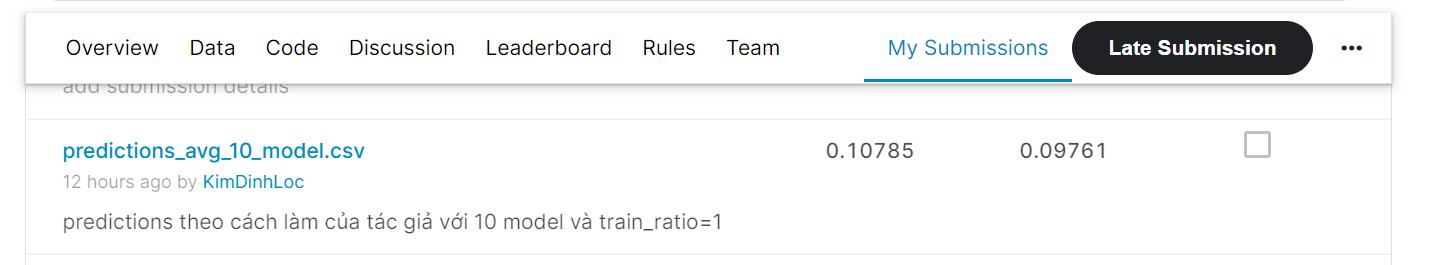

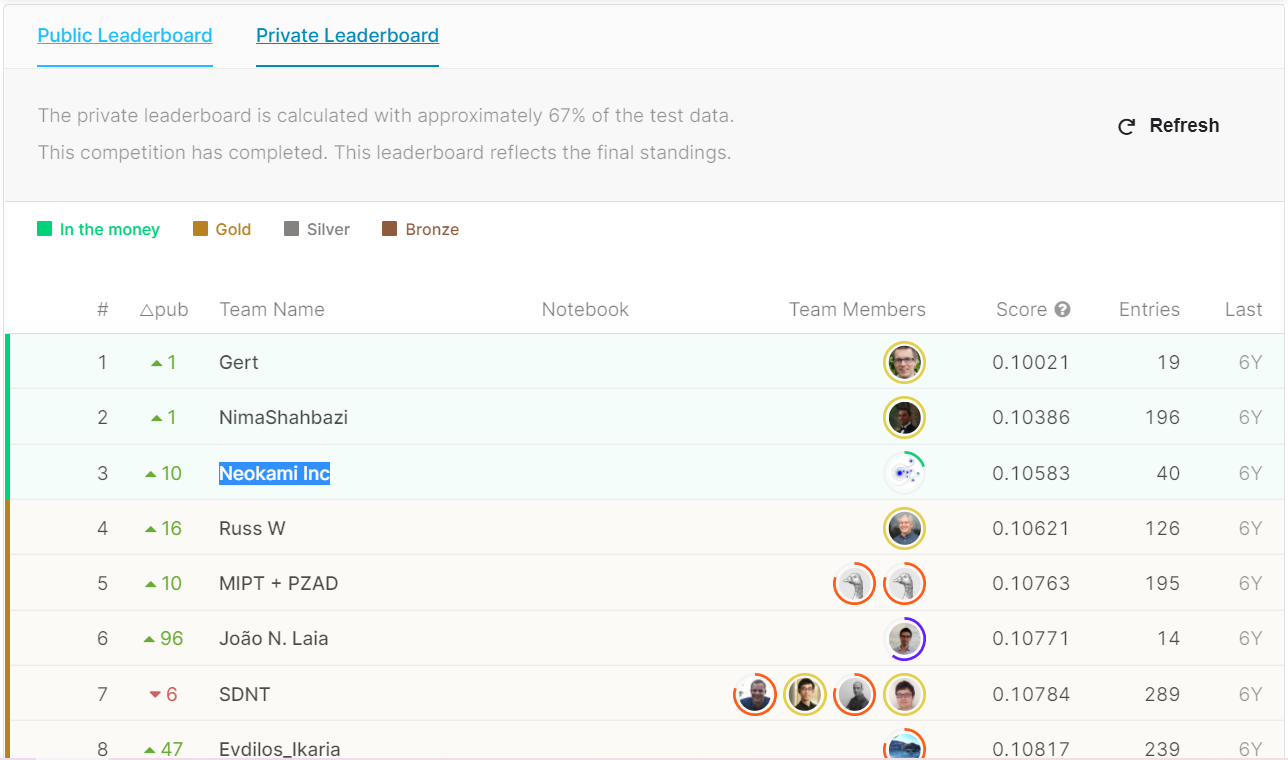

# 5.Nhìn lại quá trình làm đồ án

##### 1712568 - Kim Đình Lộc - kimdinhloc

**Khó khăn**
- Đối với em điều khó khăn đầu tiên là việc thực hiện fix code khi mà code quá cũ.
- Github, khi mà lúc đầu mới sử dụng không quen với nó, đành phải nhờ github desktop.
- Keras. Ban đầu em vẫn chưa có kinh nghiệm về thực hiện train model bằng keras.

**Lợi ích**
- Hiểu được cách mà kaggle Competition hoạt động
- Biết cách tạo ra 1 layer được tinh chỉnh

### 1712502 - Trần Quang Huy - tranquanghuy12


### 1712497 - Nguyễn Văn Huy - huynguyen12019

### 1712496 - Nguyễn Trần Công Huy - huynguyen1999

Một số khó khăn khi đối mặt với cuộc thi này:
- Mặc dù code có sẵn là 1 thuận lợi không thể bàn cãi, tuy nhiên tác giả không comment để giải thích và code không được clean.
- Kiến trúc của `model` thuộc thế hệ cũ, giai đoạn đầu không thể dùng được, cần phải thay đổi lại.
- Bước `feature engineering` của tác giả khá đơn giản, cũng như không rõ ràng trong việc đưa ra lí do tại sao.
- Bị `overfitting` khi cài lại phương pháp này dựa vào code của tác giả làm tốn rất nhiều thời gian, cứ nghĩ là do việc xử lý data có vấn đề, tuy nhiên lại vì lỗi cơ bản khi giữ input được sắp xếp theo biến `store`.

Một số điều đã học được:
- Cách sử dụng lớp `Embedding` để xử lý các biến phân loại đầu vào.
- Làm quen với việc thi cử trên `Kaggle`, đây là một sân chơi có thể giúp ta học được rất nhiều điều.

##### **Khó khăn của nhóm**
*   Khó khăn khi source code của tác giả từ năm 2018 chạy với các phiên bản tensorflow,cuda,... đã cũ nên nhóm mất khá nhiều thời gian để có thể chạy được.
*   Về những phần xử lí dữ liệu tác giả không đề cập giải thích về cách làm nên nhóm cần phải tìm hiểu để hiểu về các làm của tác giả. Phần này làm nhóm tốn nhiều thời gian nhất để có thể hiểu được ý đồ của tác giả.
*   Vỡ kế hoạch cải tiến model khi mà không đủ thời gian để làm việc nhóm khi lịch trình mỗi người khác nhau cũng như cần khá nhiều kiến thức để làm một model khác với model gốc của tác giả.
*   Ban đầu chỉ có 1 bạn là hiểu biết về neural network, nên cần nhiều thời gian hơn.  
*   Việc thực hiện nhóm chưa được suông sẻ


##### **Lợi ích mang lại khi hoàn thành đồ án**
* Tìm hiểu thêm một phương pháp có thể sử dụng dữ liệu liểu phân loại cho mô hình neural network, phương pháp này tốt hơn phương pháp mà nhóm đã biết trước đó là onehot encoding.
* Biết được các để xủ lí các dữ liệu để đưa vào mô hình, các dữ liệu nào cần thiết và không cần thiết và cần phải xử lí như thế nào.
* Hiểu rõ hơn về kaggle khi mà chúng ta biết cách để thực hiện commit hay train một model trên kaggle, cũng như cách mà cuộc thi trên kaggle diễn ra như thế nào.
* Trong quá trình phản biện thì học được cái mới của những model của ngôn ngữ tự nhiên như là BERT hay bên học thống kê.
* Hiểu biết về cách code 1 model neural network với keras.

1712497 - Nguyễn Văn Huy - huynguyen12019

**Khó khăn gặp phải**
 - Việc cài đặt thư viện rất tốn thời gian, thử đi thử lại các phiên bản nhưng vẫn xảy ra lỗi
 - Tìm hiểu entity embeddings có chút nhầm lẫn khi tìm hiểu đến đoạn embedding matrix bị nhầm về size của matrix
 - Khó khăn khi tham khảo cách xử lí dữ liệu của tác giả, vì tác giả không giải thích về phần này rõ
  
**Lợi ích mang lại**
 - Bổ sung được kiến thức khi gặp phải dữ liệu phân lớp và muốn đưa nó vào neural network, phương pháp này có phần tốt hơn onehot encoding
 - Hiểu được cách để xử lí các dạng dữ liệu, nên khai thác dữ liệu bài toán như thế nào
 - Các làm bài báo cáo trên colab và các sử dụng và tham gia cuộc thi kaggle

**Nếu có thêm thời gian...**
- Có thể sử dụng lớp Embedding này xử biến đổi các categorical features, sau đó ta concatenate chúng lại thành một input dạng numeric
=> Áp dụng các mô hình học máy như XGBoost cho bước Feature Selection cũng như để train dữ liệu.
- Đầu tư hơn cho bước Feature Engineering (tham khảo một số trong forum của cuộc thi), biết đâu có thể ra được kết quả top 1 không chừng.

# 6.Tài Liệu Tham Khảo

[Entity Embedding Paper](https://arxiv.org/pdf/1604.06737.pdf)  
[Source Code của tác giả ](https://github.com/entron/entity-embedding-rossmann/tree/kaggle)

